## Setup

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml, time, sys, os

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  
sns.set_style("darkgrid")

DATASET = "MINST"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = True
SEED = 666


In [3]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)


In [17]:
from sklearn.model_selection import train_test_split

## Datasets

In [4]:
from openml.datasets import list_datasets, get_dataset
df_openml = list_datasets(output_format="dataframe")

In [5]:
print(df_openml.shape)
df_openml

(5012, 16)


,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
2,2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45099,45099,Prostate,1,33148,active,arff,52.0,NaN,50.0,2.0,12601.0,102.0,0.0,0.0,12600.0,0.0
45100,45100,SMK,1,33148,active,arff,97.0,NaN,90.0,2.0,19994.0,187.0,0.0,0.0,19993.0,0.0
45101,45101,SRBCT,1,33148,active,arff,29.0,NaN,11.0,4.0,2309.0,83.0,0.0,0.0,2308.0,0.0
45102,45102,dailybike,1,34122,active,ARFF,4.0,NaN,1.0,606.0,13.0,731.0,0.0,0.0,12.0,1.0


In [6]:
df_openml.loc[df_openml.name.str.contains("mnist")]

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
554,554,mnist_784,1,2,active,ARFF,7877.0,10.0,6313.0,10.0,785.0,70000.0,0.0,0.0,784.0,1.0
41065,41065,mnist_rotation,1,3002,active,ARFF,NaN,NaN,NaN,0.0,785.0,62000.0,0.0,0.0,785.0,0.0


In [45]:
did = 41440

name = df_openml.loc[(df_openml.did==did), "name"].values[0]

print(f"Fetching database name:{name} id:{did}")

dataset = get_dataset(did)


Fetching database name:okcupid-stem id:41440


In [46]:
print(f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
# display(Markdown(dataset.description))


This is dataset 'okcupid-stem', the target feature is 'job'
URL: https://api.openml.org/data/v1/download/20829061/okcupid-stem.arff


In [47]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)


In [48]:
target = dataset.default_target_attribute
df = pd.DataFrame(data=X, columns=attribute_names)
df[target] = y
print(df.shape)
df.head()

(50789, 20)


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,job
0,22.0,0.0,10.0,4.0,0.0,24.0,95.0,75.0,NaN,160.0,2.0,2.0,14.0,3.0,1.0,16.0,1.0,1.0,3.0,1
1,35.0,2.0,6.0,2.0,2.0,30.0,206.0,70.0,6.0,107.0,2.0,2.0,14.0,4.0,1.0,8.0,0.0,4290.0,3.0,1
2,23.0,10.0,17.0,4.0,NaN,24.0,206.0,71.0,0.0,14.0,4.0,2.0,10.0,NaN,1.0,28.0,0.0,5978.0,3.0,2
3,29.0,1.0,NaN,4.0,0.0,9.0,21.0,66.0,NaN,141.0,NaN,2.0,14.0,NaN,1.0,0.0,0.0,1.0,3.0,1
4,29.0,2.0,3.0,4.0,NaN,9.0,206.0,67.0,NaN,141.0,2.0,2.0,10.0,5.0,1.0,40.0,0.0,560.0,3.0,0


## Preprocessing

In [49]:
print(df.shape)
df.fillna(0, inplace=True)
print(df.shape)
X, y = df[attribute_names].values, df[target].values

(50789, 20)
(50789, 20)


In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=SEED)

X_train.shape, X_val.shape, X_test.shape

((30473, 19), (10158, 19), (10158, 19))

In [51]:
n = 23
if name=='mnist_784':
    plt.imshow(X_train[n].reshape(28,28), cmap='Greys')
    plt.show()
    display(y_train[n])
else:
    display(X_train[n])
    display(y_train[n])

array([3.300e+01, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
       2.060e+02, 7.100e+01, 0.000e+00, 1.410e+02, 2.000e+00, 2.000e+00,
       1.400e+01, 6.000e+00, 1.000e+00, 1.500e+01, 0.000e+00, 3.866e+03,
       3.000e+00], dtype=float32)

1

# AdaBoost

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [62]:
base_estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(
    base_estimator=base_estimator, 
    n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=SEED)

ada_clf.fit(X_train, y_train)


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=666)

Calculate the accuracy score on train set

In [63]:
ada_clf.score(X_train, y_train)


0.7431824894168608

Calculate the accuracy score on test set

In [59]:
from sklearn.metrics import accuracy_score

In [64]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.7399094309903524

Compare the accuracy on the train set and test set. The values should be close otherwise this is an indicator of over-fitting.

In [65]:
# create a list of all possible depth values
depths = [1,2,3,4,5,6]

models = []
train_accuracy = []
val_accuracy = []

# create a list of models 
for depth in depths:
    base_estimator = DecisionTreeClassifier(max_depth=depth)
    model = AdaBoostClassifier(
        base_estimator=base_estimator, 
        n_estimators=20, algorithm="SAMME.R", learning_rate=0.5, random_state=SEED)
    model.fit(X_train, y_train)
    models.append(model)

    # evaluate model performance
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    train_accuracy.append(train_score)
    val_accuracy.append(val_score)
    print('Depth: {} Train Accuracy: {} Test Accuracy: {}'.format(depth, train_score, val_score))

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 1 Train Accuracy: 0.7300561152495652 Test Accuracy: 0.7215002953337271


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 2 Train Accuracy: 0.7357660880123388 Test Accuracy: 0.7308525300255956


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 3 Train Accuracy: 0.7451514455419552 Test Accuracy: 0.7343965347509352


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 4 Train Accuracy: 0.7501394677255275 Test Accuracy: 0.7379405394762748


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 5 Train Accuracy: 0.7572277097758672 Test Accuracy: 0.7367592045678283


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Depth: 6 Train Accuracy: 0.7664818035638106 Test Accuracy: 0.7293758613900374


Plot the train and test accuracy

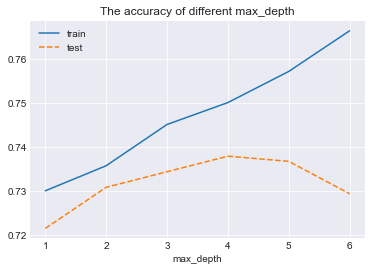

In [66]:
plt.plot(depths, train_accuracy, '-', label='train')
plt.plot(depths, val_accuracy, '--', label='test')
plt.title('The accuracy of different max_depth')
plt.xlabel("max_depth")
plt.xticks(depths)
plt.legend()
plt.show()

Questions

* According to the above figure, which one is the optimal max_depth? Why?

* What hyper-parameters can be changed too reduce over-fitting?


2. Optimal Model

Once you get the optimal depth, you could calculate model performance on the test set using the optimal model we found in the previous step.

In [67]:
best_model = models[np.argmax(val_accuracy)]
best_model.score(X_test, y_test)

0.74187832250443

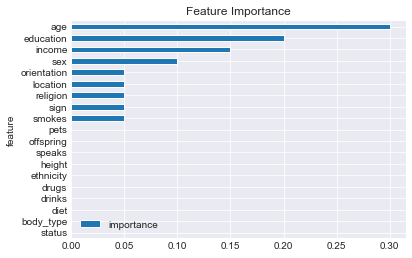

In [68]:
df_tmp = pd.DataFrame({'feature':attribute_names, 'importance':models[0].feature_importances_})

df_tmp.sort_values('importance').plot(kind='barh', x='feature')
plt.title("Feature Importance")
plt.show()

# Gradient Boosting

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

In [70]:
gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=3,
                           random_state=42)

In [71]:
y_pred = gbrt.predict(X_test)
accuracy_score(y_test, y_pred)

0.7297696396928529

In [72]:
gbrt = GradientBoostingClassifier(max_depth=2, subsample = 0.5, tol = 0.01, n_estimators=50, random_state=SEED)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=666,
                           subsample=0.5, tol=0.01)

In [74]:
from sklearn.metrics import log_loss

In [75]:
errors = [log_loss(y_val, y_pred)
          for y_pred in gbrt.staged_predict_proba(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=42)

In [76]:
min_error = np.min(errors)
min_error

0.6063669645060393

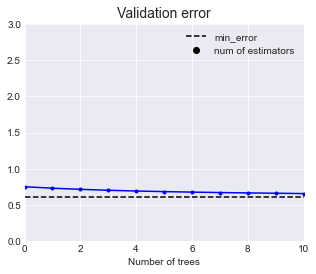

In [81]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([0, 10], [min_error, min_error], "k--", label="min_error")
plt.plot(bst_n_estimators, min_error, "ko", label="num of estimators")
plt.axis([0, 10, 0, 3])
plt.xlabel("Number of trees")
plt.legend()
plt.title("Validation error", fontsize=14)
plt.show()

Question

Tune the hyper-parameter of Gradient Boost. Try your best to optimize the model performance.

# XGBoost

In [88]:
import xgboost 

In [89]:
# filter the original data set
criteria = (df[target]==0) | (df[target]==1)
X, y = df.loc[criteria, attribute_names].values, df.loc[criteria,target].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=SEED)

X_train.shape, X_val.shape, X_test.shape


((27543, 19), (9182, 19), (9182, 19))

In [90]:
xgb = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
    use_label_encoder=False, objective='binary:logistic', eval_metric="logloss", booster='gbtree')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Test Accuracy: 0.8086473535177521


In [91]:
xgb = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100,
    use_label_encoder=False, objective='binary:logistic', eval_metric="logloss", booster='gbtree')
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", val_accuracy)


[0]	validation_0-logloss:0.65524
[1]	validation_0-logloss:0.62423
[2]	validation_0-logloss:0.59856
[3]	validation_0-logloss:0.57740
[4]	validation_0-logloss:0.55932
[5]	validation_0-logloss:0.54425
[6]	validation_0-logloss:0.53104
[7]	validation_0-logloss:0.52020
[8]	validation_0-logloss:0.51100
[9]	validation_0-logloss:0.50217
[10]	validation_0-logloss:0.49539
[11]	validation_0-logloss:0.48965


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-logloss:0.48459
[13]	validation_0-logloss:0.48019
[14]	validation_0-logloss:0.47651
[15]	validation_0-logloss:0.47319
[16]	validation_0-logloss:0.47039
[17]	validation_0-logloss:0.46786
[18]	validation_0-logloss:0.46567
[19]	validation_0-logloss:0.46354
[20]	validation_0-logloss:0.46194
[21]	validation_0-logloss:0.46056
[22]	validation_0-logloss:0.45946
[23]	validation_0-logloss:0.45843
[24]	validation_0-logloss:0.45740
[25]	validation_0-logloss:0.45649
[26]	validation_0-logloss:0.45565
[27]	validation_0-logloss:0.45486
[28]	validation_0-logloss:0.45347
[29]	validation_0-logloss:0.45236
[30]	validation_0-logloss:0.45156
[31]	validation_0-logloss:0.45083
[32]	validation_0-logloss:0.44985
[33]	validation_0-logloss:0.44928
[34]	validation_0-logloss:0.44883
[35]	validation_0-logloss:0.44816
[36]	validation_0-logloss:0.44766
[37]	validation_0-logloss:0.44695
[38]	validation_0-logloss:0.44640
[39]	validation_0-logloss:0.44620
[40]	validation_0-logloss:0.44568
[41]	validatio

# Additional Methods

If you are interested in Boosting algorithm, you could read additional material:

    LightGBM - Paper, and LightGBM - Documentation.
    CatBoost - Paper and CatBoost - Documentation.
